In [3]:
#Adam Bloodgood

# Import required libraries.
import sys           # Read system parameters.
import pandas as pd  # Manipulate and analyze data.
import sqlite3       # Manage SQL databases.
import pickle
import numpy as np                  # Work with multi-dimensional arrays.
from scipy.stats import linregress
import matplotlib                   # Create and format charts.
import matplotlib.pyplot as plt  
import seaborn as sns               # Make charting easier.
import sportypy
from sportypy.surfaces.hockey import NHLRink
import math

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- pandas {}'.format(pd.__version__))
print('- sqlite3 {}'.format(sqlite3.sqlite_version))

Libraries used in this project:
- Python 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
- pandas 2.2.3
- sqlite3 3.43.1


In [4]:
# Read in data from pickle file
data = pd.read_pickle("2023-24_player_sniper_metrics.pickle")

# Create a minimum number of shots for a goaltender to qualify for the distribution
MIN_SHOTS = 100

data = data[data['shots'] >= MIN_SHOTS]

MIN_PP_SHOTS = 20

#data = data[data['pp shots'] >= MIN_PP_SHOTS]

#MIN_GOALS = 10
#data = data[data['goals'] >= MIN_GOALS]

#data = data[data['goals'] >= MIN_GOALS]

#Generate rankings for players based on different metrics
len_array = []
for i in range(1, len(data)+1):
    len_array.append(int(i))

data = data.sort_values(by = ['shooting%'], ascending=False)
data['shot ranking'] = len_array
data = data.sort_values(by = ['adjusted shooting%'], ascending=False)
data['sniper ranking'] = len_array

len_array = []
for i in range(1, len(data)+1):
    len_array.append(float(i))

data['expected shooting%'] = len_array
data['shooting per. above expected'] = len_array

#Generate lines of best fit 
slope, intercept, r_value, p_value, std_err = linregress(data['avg. shot difficulty'], data['shooting%'])

pp_slope, pp_intercept, r_value, p_value, std_err = linregress(data['avg. pp shot difficulty'], data['pp shooting%'])

ev_slope, ev_intercept, r_value, p_value, std_err = linregress(data['avg. ev shot difficulty'], data['ev shooting%'])

#Calculate more metrics
data['rating difference'] = len_array
for index, player in data.iterrows():
    data.at[index, 'rating difference'] = int(player['shot ranking'] - player['sniper ranking'])
    expected = (slope * player['avg. shot difficulty']) + intercept
    data.at[index, 'expected shooting%'] = expected
    data.at[index, 'shooting per. above expected'] = (player['shooting%'] / expected) - 1
    pp_expected = (pp_slope * player['avg. pp shot difficulty']) + pp_intercept
    data.at[index, 'expected pp shooting%'] = pp_expected
    data.at[index, 'pp shooting per. above expected'] = (player['pp shooting%'] / pp_expected) - 1
    ev_expected = (ev_slope * player['avg. ev shot difficulty']) + ev_intercept
    data.at[index, 'expected ev shooting%'] = expected
    data.at[index, 'ev shooting per. above expected'] = (player['ev shooting%'] / ev_expected) - 1
    data.at[index, 'ev to pp shot difference'] = player['avg. ev shot difficulty'] - player['avg. pp shot difficulty'] 

#Create copies of the dataframe by position
#data = data.filter(like='Reinhart, Sam', axis = 0) #Search for specific player
data = data.sort_values(by = ['shooting per. above expected'], ascending=False)
data_d = data[data['position'] == 'D']
data_f = data[data['position'].isin(['C', 'L', 'R'])]

with pd.option_context('display.max_columns', None): display(data_d)


,position,avg. shot difficulty,avg. goal difficulty,adjusted shooting%,shot-goal difference,avg. pp shot difficulty,avg. pp goal difficulty,adjusted pp shooting%,pp shot-goal difference,avg. ev shot difficulty,avg. ev goal difficulty,adjusted ev shooting%,ev shot-goal difference,shots,pp shots,ev shots,goals,pp goals,ev goals,shooting%,pp shooting%,ev shooting%,shot locations (non-goals),pp shot locations (non-goals),ev shot locations (non-goals),goal locations,pp goal locations,ev goal locations,shot ranking,sniper ranking,expected shooting%,shooting per. above expected,rating difference,expected pp shooting%,pp shooting per. above expected,expected ev shooting%,ev shooting per. above expected,ev to pp shot difference
"Fox, Adam",D,0.951323,0.917156,0.124404,-0.034168,0.950248,0.932564,0.162900,-0.017684,0.951719,0.908751,0.110199,-0.042968,130,35,95,17,6,11,0.130769,0.171429,0.115789,"[[42, 20, right], [-79, 6, left], [-66, -27, l...","[[-66, -27, left], [42, -15, right], [-37, 19,...","[[42, 20, right], [-79, 6, left], [68, 26, rig...","[[85, 13, right], [73, 26, right], [84, 6, rig...","[[85, 13, right], [73, 26, right], [84, 6, rig...","[[29, -12, right], [-81, -2, left], [83, 18, r...",102,83,0.080875,0.616932,19.0,0.135398,0.266110,0.080875,0.540080,0.001471
"Doughty, Drew",D,0.958978,0.949330,0.101710,-0.009649,0.955543,0.957209,0.185800,0.001666,0.960267,0.941451,0.070019,-0.018816,132,36,96,14,7,7,0.106061,0.194444,0.072917,"[[-36, -29, left], [-29, 4, left], [79, 10, ri...","[[-36, -29, left], [-40, -22, left], [38, 26, ...","[[-29, 4, left], [79, 10, right], [35, 6, righ...","[[-50, -19, left], [41, 9, right], [-34, 18, l...","[[41, 9, right], [-40, 7, left], [-45, 5, left...","[[-50, -19, left], [-34, 18, left], [-38, -8, ...",168,153,0.073167,0.449571,15.0,0.135844,0.431380,0.073167,0.102455,0.004723
"Weegar, MacKenzie",D,0.960715,0.950823,0.096071,-0.009892,0.959437,0.953477,0.099252,-0.005960,0.960945,0.950325,0.095498,-0.010620,190,29,161,19,3,16,0.100000,0.103448,0.099379,"[[-57, 17, left], [46, -20, right], [80, -31, ...","[[-48, 15, left], [77, -6, right], [-50, -33, ...","[[-57, 17, left], [46, -20, right], [80, -31, ...","[[-32, 18, left], [-58, -17, left], [-52, -14,...","[[-58, -17, left], [-56, 19, left], [50, -2, r...","[[-32, 18, left], [-52, -14, left], [-37, 28, ...",190,175,0.071419,0.400194,15.0,0.136172,-0.240312,0.071419,0.519027,0.001507
"Harley, Thomas",D,0.951180,0.889916,0.104144,-0.061264,0.962203,0.965558,0.050642,0.003355,0.949405,0.884513,0.112641,-0.064892,137,19,118,15,1,14,0.109489,0.052632,0.118644,"[[-35, -28, left], [-52, 0, left], [33, 7, rig...","[[-49, -3, left], [50, -3, right], [-49, 15, l...","[[-35, -28, left], [-52, 0, left], [33, 7, rig...","[[-52, 8, left], [-80, -7, left], [-64, 20, le...","[[38, 15, right]]","[[-52, 8, left], [-80, -7, left], [-64, 20, le...",158,147,0.081019,0.351403,11.0,0.136405,-0.614153,0.081019,0.528282,-0.012798
"Makar, Cale",D,0.955410,0.938262,0.092035,-0.017148,0.958085,0.961657,0.094459,0.003573,0.954119,0.926565,0.090868,-0.027554,218,71,147,21,7,14,0.096330,0.098592,0.095238,"[[37, -24, right], [-41, -3, left], [-30, 2, l...","[[-41, -3, left], [-30, 2, left], [-40, -14, l...","[[37, -24, right], [-29, 41, left], [-48, -26,...","[[-49, 12, left], [-44, 1, left], [-70, -10, l...","[[-49, 12, left], [32, -2, right], [-31, 7, le...","[[-44, 1, left], [-70, -10, left], [-61, 9, le...",202,187,0.076759,0.254963,15.0,0.136058,-0.275372,0.076759,0.311005,-0.003966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Ferraro, Mario",D,0.963144,0.958024,0.025570,-0.005120,0.970990,0.000000,0.000000,-0.970990,0.963003,0.958024,0.026027,-0.004979,113,2,111,3,0,3,0.026549,0.000000,0.027027,"[[27, 39, right], [84, -7, right], [73, 12, ri...","[[-31, 12, left], [-77, -27, left]]","[[27, 39, right], [84, -7, right], [73, 12, ri...","[[58, 28, right], [

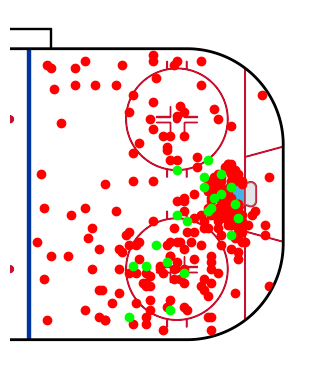

In [5]:
#Generate shot chart of individual players

player_data = data.filter(like='Tkachuk, Matthew', axis = 0) #Search for specific player

x_coords_shots = []
y_coords_shots = []
shots = player_data['shot locations (non-goals)'].iloc[0]
for i in range(0, len(shots)):
    if shots[i][2] == 'left':
        x = shots[i][0] * -1
        y = shots[i][1] * -1
    else:
        x = shots[i][0]
        y = shots[i][1]
    
    x_coords_shots.append(x)
    y_coords_shots.append(y)

x_coords_goals = []
y_coords_goals = []
shots = player_data['goal locations'].iloc[0]
for i in range(0, len(shots)):
    if shots[i][2] == 'left':
        x = shots[i][0] * -1
        y = shots[i][1] * -1
    else:
        x = shots[i][0]
        y = shots[i][1]
    
    x_coords_goals.append(x)
    y_coords_goals.append(y)

nhl = NHLRink()
fig, ax = plt.subplots(1, 1)
nhl.draw(display_range="ozone", ax = ax)

nhl.scatter(x_coords_shots, y_coords_shots, color = '#ff0000')
nhl.scatter(x_coords_goals, y_coords_goals, color = '#00ff00')



Text(0, 0.5, 'Number of Players')

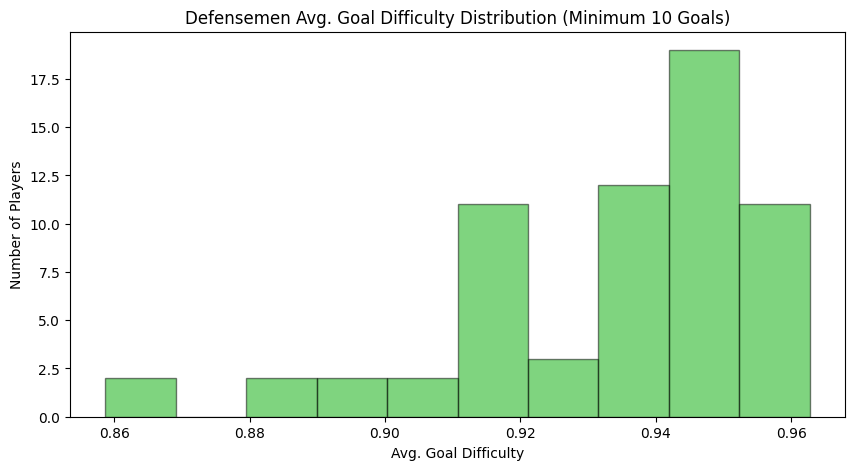

In [6]:
# Print histogram of distribution
data_d['avg. goal difficulty'].hist(figsize = (10,5), color = '#00aa00', alpha = 0.5,
                        edgecolor = 'black', grid = False)
plt.title(f"Defensemen Avg. Goal Difficulty Distribution (Minimum 10 Goals)")
plt.xlabel("Avg. Goal Difficulty")
plt.ylabel("Number of Players")

Text(0.5, 1.0, 'Average Shot Difficulty VS Shooting %')

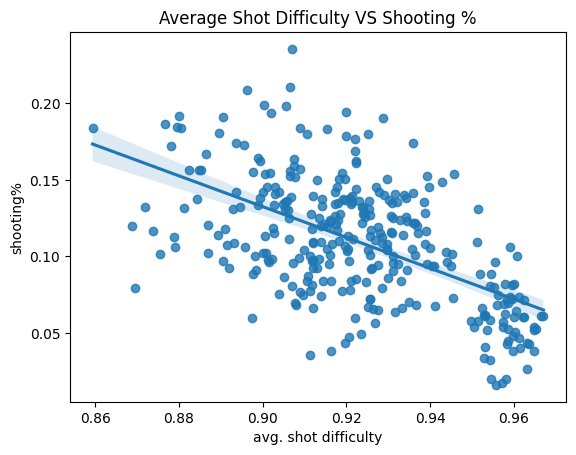

In [7]:
# Show scatter plot with line of best fit
sns.regplot(data = data, x = 'avg. shot difficulty', y = 'shooting%')
plt.title("Average Shot Difficulty VS Shooting %")

In [8]:
# Show statistical numbers of distribution
data_f['shooting per. above expected'].describe()

count    256.000000
mean       0.038640
std        0.298322
min       -0.705336
25%       -0.196078
50%        0.052057
75%        0.232000
max        0.877959
Name: shooting per. above expected, dtype: float64

Text(0.5, 1.0, 'Avg. Shot Difficulty VS. Shooting %')

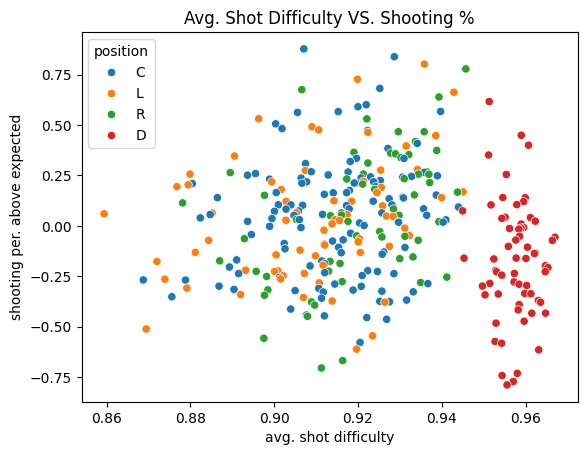

In [9]:
#Create scatterplot with color based on position
sns.scatterplot(data = data, x = 'avg. shot difficulty',
               y = 'shooting per. above expected', hue = 'position')
#plt.plot(data['avg. shot difficulty'], slope * data['avg. shot difficulty'] + intercept,)
plt.title("Avg. Shot Difficulty VS. Shooting %")


In [11]:
#Create tables showing top/bottom 5 players of different metrics

from great_tables import GT, md, style, loc

MIN_SHOTS = 80
MIN_GOALS = 10

table_used = data_f

#new_data = table_used[table_used['ev shots'] >= MIN_PP_SHOTS]
new_data = table_used[table_used['ev goals'] >= MIN_GOALS]
#new_data = table_used



metric = 'avg. ev goal difficulty'
top_data = pd.DataFrame(new_data.sort_values(by = metric, ascending=False).head(n=5)[metric]).reset_index().rename(columns={'index': 'Player'})
bottom_data = pd.DataFrame(new_data.sort_values(by = metric, ascending=True).head(n=5)[metric]).reset_index().rename(columns={'index': 'Player'})

for index, player in top_data.iterrows():
    top_data.at[index, metric] = round(top_data.at[index, metric], 4)
for index, player in bottom_data.iterrows():
    bottom_data.at[index, metric] = round(bottom_data.at[index, metric], 4)
display(top_data)
display(bottom_data)

display(
    GT(top_data)
    .tab_header(title= md(f"**Top 5 {metric}**"), subtitle="Minimum 10 goals.")
    .tab_style(style = style.text(weight = 'bold'), locations = loc.body(columns = 'Player'))\
    .tab_stub(rowname_col='Player')
)
display(
    GT(bottom_data)
    .tab_header(title=md(f"**Bottom 5 {metric}**"), subtitle="Minimum 10 goals.")
    .tab_style(style = style.text(weight = 'bold'), locations = loc.body(columns = 'Player'))
    .tab_stub(rowname_col='Player')
)

,Player,avg. ev goal difficulty
0,"Johansson, Marcus",0.9343
1,"Skinner, Jeff",0.9309
2,"Nylander, William",0.9296
3,"Larkin, Dylan",0.9288
4,"Fantilli, Adam",0.9281


,Player,avg. ev goal difficulty
0,"Niederreiter, Nino",0.7177
1,"Noesen, Stefan",0.7550
2,"Atkinson, Cameron",0.7638
3,"Cooley, Logan",0.7690
4,"Kurashev, Philipp",0.7788


GT(_tbl_data=              Player  avg. ev goal difficulty
0  Johansson, Marcus                   0.9343
1      Skinner, Jeff                   0.9309
2  Nylander, William                   0.9296
3      Larkin, Dylan                   0.9288
4     Fantilli, Adam                   0.9281, _body=<great_tables._gt_data.Body object at 0x000001EE5116A810>, _boxhead=Boxhead([ColInfo(var='Player', type=<ColInfoTypeEnum.stub: 2>, column_label='Player', column_align='left', column_width=None), ColInfo(var='avg. ev goal difficulty', type=<ColInfoTypeEnum.default: 1>, column_label='avg. ev goal difficulty', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001EE5114EF30>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Top 5 avg. ev goal difficulty**'), subtitle='Minimum 10 goals.', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x000001EE5114F260>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value=

GT(_tbl_data=               Player  avg. ev goal difficulty
0  Niederreiter, Nino                   0.7177
1      Noesen, Stefan                   0.7550
2   Atkinson, Cameron                   0.7638
3       Cooley, Logan                   0.7690
4   Kurashev, Philipp                   0.7788, _body=<great_tables._gt_data.Body object at 0x000001EE5114D430>, _boxhead=Boxhead([ColInfo(var='Player', type=<ColInfoTypeEnum.stub: 2>, column_label='Player', column_align='left', column_width=None), ColInfo(var='avg. ev goal difficulty', type=<ColInfoTypeEnum.default: 1>, column_label='avg. ev goal difficulty', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001EE516DA2A0>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Bottom 5 avg. ev goal difficulty**'), subtitle='Minimum 10 goals.', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Player', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x000001EE5131C230>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px